## Visualizing vector models of documents
---
This is a quick and simple tutorial on some approaches to generating vectors models of documents and visualizing
2D projections of the vectors space. All of the python libraries we import should be straightforward to install with pip if you don't have them.

We'll also be using a tool called LargeVis for visualization. Unfortunately this tool is persnickity and doesn't work out of the box with Python3. Thus I would install it following the instructions [here](https://github.com/lferry007/LargeVis) and install the python wrapper into a python2 env (otherwise you can run it directly in c++).

### Imports and setup

In [46]:
import math

import pandas
import matplotlib
from matplotlib import pyplot
# need this to render plots in the notebook
%matplotlib inline 
# for progress bars! See https://github.com/tqdm/tqdm
from tqdm import tqdm_notebook 
# seaborn is a great little plotting library, with useful defualt templates
# (and lots of other neat features; a good topic for future tutorial!)
from seaborn import color_palette 
# Gensim and spacy are two of the most commonly-used python NLP libraries
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import spacy

# These are all the necessary imports for visualization in boken and datashader
from bokeh import plotting
from datashader.bokeh_ext import InteractiveImage
import datashader


We're going to be doing some vector modeling of movie summaries ("overview" column), so let's load the data into a pandas dataframe and drop any rows without a summary. We'll also extract the first genre from the genres column


In [38]:
def get_genre(s):
    """"Helper function to extract a movie's genre from the genre column"""
    try:
        return (eval(s)[0])['name']
    except:
        return 'unknown'
    
metadata = pandas.read_csv('../data/kaggle-imdb-data/movies_metadata.csv', low_memory=False)
metadata = metadata.dropna(subset=['overview']).reset_index()
metadata['genre'] = metadata.genres.apply(get_genre)
metadata[['overview', 'genre']].head()


overview      genre
0  Led by Woody, Andy's toys live happily in his ...  Animation
1  When siblings Judy and Peter discover an encha...  Adventure
2  A family wedding reignites the ancient feud be...    Romance
3  Cheated on, mistreated and stepped on, the wom...     Comedy
4  Just when George Banks has recovered from his ...     Comedy

## Vector modeling

We'll take two approaches to generating the document vector representations: Training our own model with [Gensim](https://radimrehurek.com/gensim/)'s implementation of Doc2vec and mapping to pre-trained vectors from [Spacy](https://spacy.io/).

In [7]:
# Running a doc2vec model is really simple! We just convert each document into 
# Gensim Tagged Document object, then pass them into the Doc2Vec function. Note
# that we're just splitting the docs on whitespace here, but in a real application
# should use a more sophisticated tokenization approach. I've also set sensible
# defaults for the Doc2Vec parameters, but this is something we'd also ideally
# do some experimentation with
documents = [TaggedDocument(doc.split(), [i]) for i, doc in enumerate(metadata.overview)]
model = Doc2Vec(documents, vector_size=200, window=10, min_count=10, workers=4, alpha=0.025, steps=100)
vectors = model.docvecs.vectors_docs

# Now that we have our document vectors, we need to write them to a file compatible
# with LargeVis, which generates the 2D embedding of the high-dimensional vectores
with open('lv_format_d2v.txt','w') as out:
    # first line is the dimensionality of the vector matrix
    out.write("{}\t{}\n".format(*vectors.shape))
    for row in tqdm_notebook(vectors):
        out.write('\t'.join(row.astype(str))+'\n')

HBox(children=(IntProgress(value=0, max=44512), HTML(value='')))

In [9]:
# Given the small size of our data, we might not get the best vectors with the 
# model we train ourselves, so our second approach will use Spacy's pre-trained
# document vectors. This loop just feed each document through spacy and extracts
# the mapped vector, then writes to a file like we do in the previous cell

# Load spacy's nlp model (lg --> "large" vectors)
nlp = spacy.load('en_core_web_lg', disable=['tagger', 'ner', 'textcat'])
with open('lv_format_spacy.txt','w') as out:
    # first line is the dimensionality of the vector matrix
    out.write("{}\t{}\n".format(len(metadata), 300))
    for doc in tqdm_notebook(metadata.overview):
        out.write('\t'.join(nlp(doc).vector.astype(str))+'\n')

HBox(children=(IntProgress(value=0, max=44512), HTML(value='')))

## LargeVis dimensionality reduction

Now it's time to run LargeVis. Outside this notebook (after getting LargeVis set up) you'll want to run the following code:

```
python /path/to/LargeVis_run.py -input lv_format_d2v.txt -output embedding_d2v.txt
python /path/to/LargeVis_run.py -input lv_format_spacy.txt -output embedding_spacy.txt
```

(Make sure you're using Pyhton 2 for this part)

This will take a bit, but when it's done you'll have files for both vector embeddings. Each file will have coordinates for each document, projected into a 2-dimensional vector space.

## Visualization

Now we get to make some pretty pictures! To accomplish this, we'll use [datashader](http://datashader.org/), which cna handle plotting millions of datapoints with ease, plus [bokeh](http://bokeh.pydata.org) for interactivity with the plot. We'll start by making some helper functions to generate the plots we want.

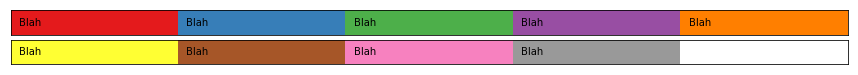

In [34]:
# Just a clunky little function to generate a legend (given color pallette and labels) as
# an independent matplotlib figure. This is super ugly and I just haven't had a chance to
# go back and make something better...
def keyplot(pal, names, columns=5):
    n = len(pal)
    rows = math.ceil(n/columns)
    f, axes = pyplot.subplots(rows, 1, figsize=(15, .5*rows))
    if rows ==1:
        axes = [axes,]
    for idx,ax in enumerate(axes):
        current_pal = pal[idx*columns:(idx*columns)+columns]
        if len(current_pal)<columns:
            current_pal += ['white']*(columns-len(current_pal))
        current_names = names[idx*columns:(idx*columns)+columns]
        ax.imshow(
            numpy.arange(columns).reshape(1, columns),
            cmap=matplotlib.colors.ListedColormap(list(current_pal)),
            interpolation="nearest",
            aspect="auto")
        ax.set_xticks(numpy.arange(columns) - .5)
        ax.set_yticks([-.5, .5])
        for i,name in enumerate(current_names):
            ax.annotate(name,(-.45+i,0.1))
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticklabels([])
        ax.set_yticks([])

# Example:
keyplot(color_palette('Set1',9),names=['Blah']*9)

In [55]:
# This sets up some default parameters for generating the base plot that we'll
# generate. We'll then add interactiving on top of it
plotting.output_notebook()
x_range = (-24,20)
y_range = (-24,24)
plot_width = 800
plot_height = 800

def base_plot(tools='pan,wheel_zoom,reset,box_zoom'):
    p = plotting.figure(
        tools=tools, plot_width=plot_width, plot_height=plot_height,
        outline_line_color=None, x_range=x_range, y_range=y_range,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0)
    
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.background_fill_color = "black"
    
    return p

Loading BokehJS ...

In [48]:
# This is the callback method to actually generate our visualization.
# The first four arguments are required, and we additionally specify a topN
# parameter that we can pass to `InteractiveImage`. This tells the code to only
# render the top N most frequest values for gender (in practice it's hard to
# distinguish more than 9 colors, which is what is specified in the keyplot
# function above)
def image_callback(x_range=x_range, y_range=y_range, w=plot_width, h=plot_height, topN=9):
    cat = 'genre'
    # filter to known genres
    df = plot_data[plot_data.genre != 'unknown'].copy()
    # Filter to only the top N most common genres
    if topN is not None:
        topN = df[cat].value_counts()[:topN].index.values
        df = df[df[cat].isin(topN)]
       
    unique_values = sorted(df[cat].unique())
    # This is an annoying hack to translate seaborn's color palette values into
    # a format compatible with datashader
    colors = [
        '#%02x%02x%02x' % (a, b, c) for a,b,c in
        numpy.round(255*numpy.array(color_palette('Set1',n_colors=len(unique_values)))).astype(int)]
    # generate a keyplot showing which genres correspond to which colors
    keyplot(colors, unique_values)
    color_key = {val:color for val,color in zip(unique_values,colors)}
    df[cat] = df[cat].astype('category')
    
    # Generate the datashder image, with each point colored by genre
    cvs = datashader.Canvas(plot_width=w, plot_height=h,x_range=x_range, y_range=y_range)
    agg = cvs.points(df, 'x', 'y', datashader.count_cat('genre'))
    img = datashader.transfer_functions.shade(agg, color_key=color_key, how='eq_hist')
    # dynspread just makes points expand a bit when you zoom in
    return datashader.transfer_functions.dynspread(img,threshold=0.75, max_px=8)


## Final images!

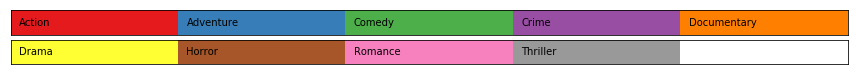

In [54]:
plot_data = pandas.read_table('embedding_d2v.txt',header=None,skiprows=1,names=['x','y'],delimiter=' ')
plot_data['genre'] = metadata.genre
p = base_plot()
InteractiveImage(p, image_callback, topN=9)

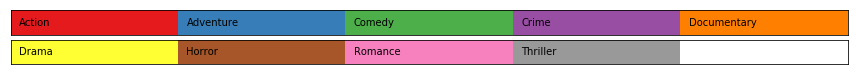

In [56]:
plot_data = pandas.read_table('embedding_spacy.txt',header=None,skiprows=1,names=['x','y'],delimiter=' ')
plot_data['genre'] = metadata.genre
p = base_plot()
InteractiveImage(p, image_callback)